In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

# Load the dataset
df = pd.read_csv(r"hotel_bookings.csv")
print(df)

               hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July     

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
# check for missing values
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

## Data preprocessing

### Missing Values

In [ ]:
# Replace missing values:
# children: if null, the amount shall be zero
# country: if null, it shall be unknown
# agent: If null, booking was likely made without agent
# company: If null, it was most likely a private company

null_replacements = {"children:": 0,"country": "Unknown", "agent": 0, "company": 0}
df_cln = df.fillna(null_replacements)

# feature meal contains values: Undefined, which is equal to SC
df_cln["meal"].replace("Undefined", "SC", inplace=True)

# Drop rows contain entreis with 0 adults, 0 children and 0 babies.
zero_guests = list(df_cln.loc[df_cln["adults"]
                   + df_cln["children"]
                   + df_cln["babies"]==0].index)
df_cln.drop(df_cln.index[zero_guests], inplace=True)

In [ ]:
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  object 
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_year               119210 non-null  int64  
 4   arrival_date_month              119210 non-null  object 
 5   arrival_date_week_number        119210 non-null  int64  
 6   arrival_date_day_of_month       119210 non-null  int64  
 7   stays_in_weekend_nights         119210 non-null  int64  
 8   stays_in_week_nights            119210 non-null  int64  
 9   adults                          119210 non-null  int64  
 10  children                        119206 non-null  float64
 11  babies                          119210 non-null  int64  
 12  meal            

### Correlations

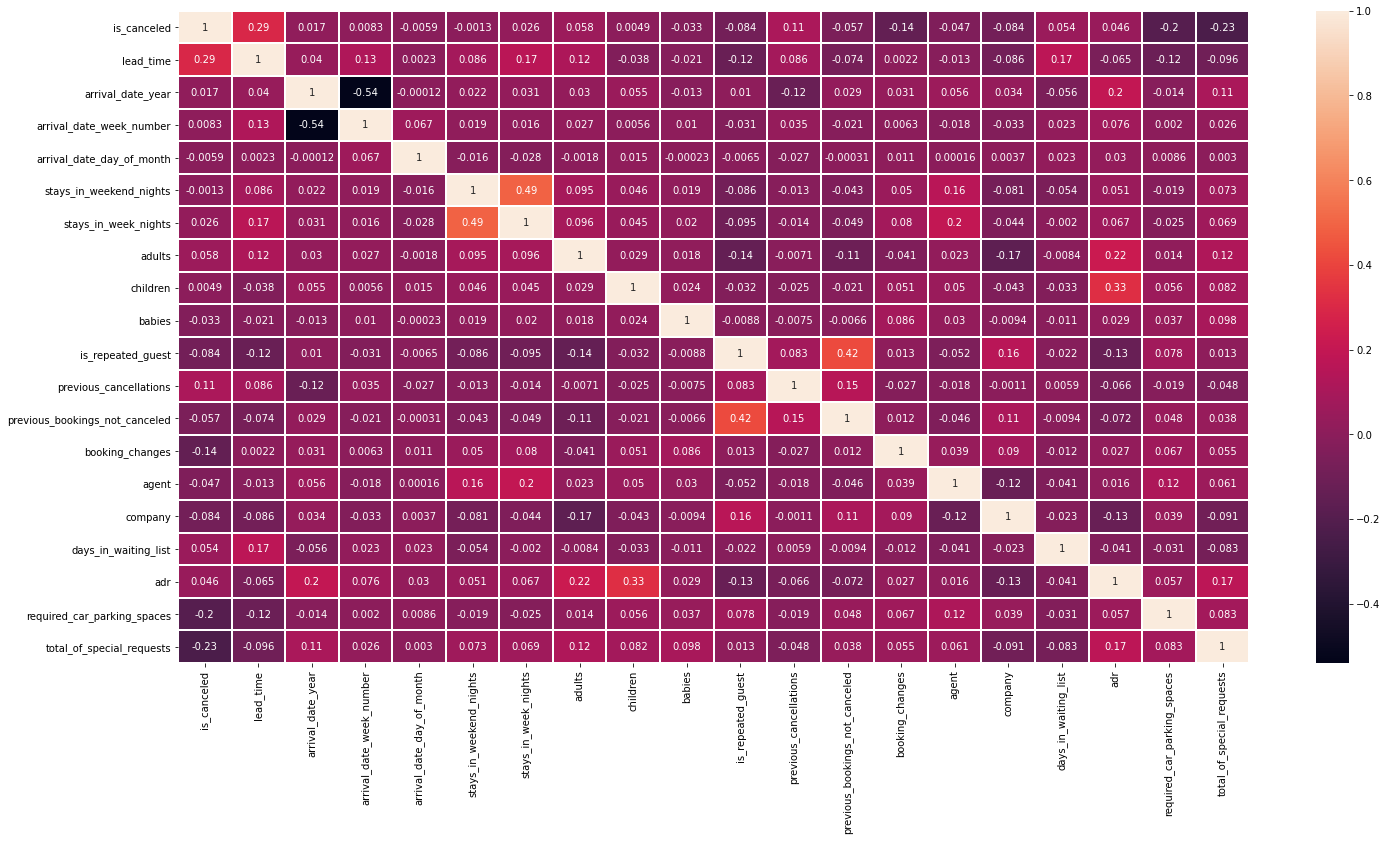

In [ ]:
plt.figure(figsize = (24, 12))

corr_matrix = df_cln.corr()
sns.heatmap(corr_matrix, annot = True, linewidths = 1)
plt.show()

In [ ]:
#Explore which numerical features are correlated with the response
corr_with_cancel = corr_matrix["is_canceled"]
corr_with_cancel.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004862
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

## Feature Engineering

In [ ]:
# differentiate numerical and categorical dataframes

cat_cols = [col for col in df_cln.columns if df_cln[col].dtype == 'O']
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [ ]:
cat_df = df_cln[cat_cols]
cat_df.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,2015-07-02
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,2015-07-02
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-07-03


In [ ]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

In [ ]:
cat_df.drop(['reservation_status_date','reservation_status','arrival_date_month','country'] , axis = 1, inplace = True)

In [ ]:
# encoding categorical variables

cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['market_segment'] = cat_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['distribution_channel'] = cat_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                   'H': 7, 'L': 8, 'P': 9})
cat_df['assigned_room_type'] = cat_df['assigned_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                   'H': 7, 'I':8, 'K':9,'L': 10, 'P': 11})
cat_df['deposit_type'] = cat_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['customer_type'] = cat_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

In [ ]:
cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,year,month,day
0,0,0,0,0,2,2,0,0,0,7,1
1,0,0,0,0,2,2,0,0,0,7,1
2,0,0,0,0,0,2,0,0,0,7,2
3,0,0,1,1,0,0,0,0,0,7,2
4,0,0,2,2,0,0,0,0,0,7,3


In [ ]:
num_df = df_cln.drop(columns = cat_cols, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)
num_df

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,0.0,0.0,0,0.00,0,0
1,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,0.0,0.0,0,0.00,0,0
2,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0.0,0.0,0,75.00,0,0
3,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,304.0,0.0,0,75.00,0,0
4,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,240.0,0.0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,394.0,0.0,0,96.14,0,0
119386,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,9.0,0.0,0,225.43,0,2
119387,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,9.0,0.0,0,157.71,0,4
119388,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,89.0,0.0,0,104.40,0,0


In [ ]:
num_df.var()

lead_time                         11422.361808
arrival_date_year                     0.500535
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159075
babies                                0.009508
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
booking_changes                       0.407688
agent                             11485.169679
company                            2897.684308
days_in_waiting_list                309.689671
adr                                2543.589039
required_car_parking_spaces           0.060201
total_of_special_requests             0.628652
dtype: float64

In [ ]:
# normalizing numerical variables

num_df['lead_time'] = np.log(num_df['lead_time'] + 1)
num_df['arrival_date_week_number'] = np.log(num_df['arrival_date_week_number'] + 1)
num_df['arrival_date_day_of_month'] = np.log(num_df['arrival_date_day_of_month'] + 1)
num_df['agent'] = np.log(num_df['agent'] + 1)
num_df['company'] = np.log(num_df['company'] + 1)
num_df['adr'] = np.log(num_df['adr'] + 1)
num_df.var()

lead_time                           2.582757
arrival_date_year                   0.500535
arrival_date_week_number            0.440884
arrival_date_day_of_month           0.506325
stays_in_weekend_nights             0.990258
stays_in_week_nights                3.599010
adults                              0.330838
children                            0.159075
babies                              0.009508
is_repeated_guest                   0.030507
previous_cancellations              0.713887
previous_bookings_not_canceled      2.244415
booking_changes                     0.407688
agent                               3.535793
company                             1.346883
days_in_waiting_list              309.689671
adr                                 0.515480
required_car_parking_spaces         0.060201
total_of_special_requests           0.628652
dtype: float64

In [ ]:
num_df.drop('days_in_waiting_list', axis = 1, inplace = True)
num_df.drop('arrival_date_year', axis = 1, inplace = True)
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())
num_df['children'] = num_df['children'].fillna(0)
num_df

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,5.837730,3.332205,0.693147,0,0,2,0.0,0,0,0,0,3,0.000000,0.0,0.000000,0,0
1,6.603944,3.332205,0.693147,0,0,2,0.0,0,0,0,0,4,0.000000,0.0,0.000000,0,0
2,2.079442,3.332205,0.693147,0,1,1,0.0,0,0,0,0,0,0.000000,0.0,4.330733,0,0
3,2.639057,3.332205,0.693147,0,1,1,0.0,0,0,0,0,0,5.720312,0.0,4.330733,0,0
4,2.708050,3.332205,0.693147,0,2,2,0.0,0,0,0,0,0,5.484797,0.0,4.595120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,3.178054,3.583519,3.433987,2,5,2,0.0,0,0,0,0,0,5.978886,0.0,4.576153,0,0
119386,4.634729,3.583519,3.465736,2,5,3,0.0,0,0,0,0,0,2.302585,0.0,5.422436,0,2
119387,3.555348,3.583519,3.465736,2,5,2,0.0,0,0,0,0,0,2.302585,0.0,5.067079,0,4
119388,4.700480,3.583519,3.465736,2,5,2,0.0,0,0,0,0,0,4.499810,0.0,4.657763,0,0


In [ ]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df_cln['is_canceled']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  int64  
 1   meal                            119210 non-null  int64  
 2   market_segment                  119210 non-null  int64  
 3   distribution_channel            119210 non-null  int64  
 4   reserved_room_type              119210 non-null  int64  
 5   assigned_room_type              119210 non-null  int64  
 6   deposit_type                    119210 non-null  int64  
 7   customer_type                   119210 non-null  int64  
 8   year                            119210 non-null  int64  
 9   month                           119210 non-null  int64  
 10  day                             119210 non-null  int64  
 11  lead_time                       119210 non-null  float64
 12  arrival_date_wee

In [ ]:
X.shape, y.shape

((119210, 28), (119210,))

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

## Model building and selection

In [ ]:
from sklearn.metrics import roc_auc_score
def modelEvaluation(modelUsed,Xtrain,ytrain,Xtest,ytest,threshold):
    if 'CatBoostClassifier' in str(modelUsed):
      modelUsed.fit(Xtrain,ytrain,eval_set=(Xtest,ytest),verbose=False,plot=True)
    else:
      modelUsed.fit(Xtrain,ytrain)
    yTrainProbability=modelUsed.predict_proba(Xtrain)[:,1]
    yTrainPrediction=np.where(yTrainProbability>threshold,1,0)

    yTestProbability=modelUsed.predict_proba(Xtest)[:,1]
    yTestPrediction=np.where(yTestProbability>threshold,1,0)

    print(modelUsed)

    #run only for the best model to save predicted values - if needed
    #We used this to calculate the expected true demand
    yTestPredictionseries = pd.DataFrame(yTestPrediction)
    yTestPredictionseries.to_csv(r"C:\Users\zhouh\OneDrive\Desktop\MMA 867 Project\prediction.csv")


    #results
    #confusion matrix
    print("\n")
    print(' Confusion Matrix: Train: \n ')
    data = {'y_Actual': ytrain,'y_Predicted': yTrainPrediction}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True,cmap='Blues',fmt="d")
    plt.show()
    print("\n")
    print(' Confusion Matrix: Test: \n ')
    data = {'y_Actual': ytest,'y_Predicted': yTestPrediction}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True,cmap='Blues',fmt="d")
    plt.show()
    #auc roc
    print("\n")
    print(' AUC_ROC: Train: \n ', roc_auc_score(ytrain,yTrainProbability))
    print(' AUC_ROC: Test: \n ', roc_auc_score(ytest,yTestProbability))
    # recall score
    print("\n")
    print('Classification Report: Train \n', classification_report(ytrain,yTrainPrediction))
    print('Classification Report: Test \n', classification_report(ytest,yTestPrediction))


### Logistic Regression

LogisticRegression(random_state=20)


 Confusion Matrix: Train: 
 


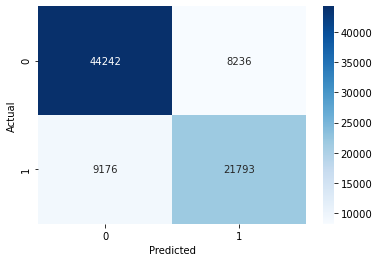



 Confusion Matrix: Test: 
 


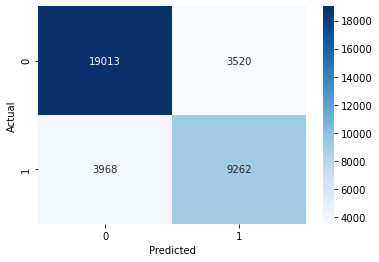



 AUC_ROC: Train: 
  0.8602403803222212
 AUC_ROC: Test: 
  0.8584523936154242


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84     52478
           1       0.73      0.70      0.71     30969

    accuracy                           0.79     83447
   macro avg       0.78      0.77      0.78     83447
weighted avg       0.79      0.79      0.79     83447

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84     22533
           1       0.72      0.70      0.71     13230

    accuracy                           0.79     35763
   macro avg       0.78      0.77      0.77     35763
weighted avg       0.79      0.79      0.79     35763

Accuracy Score of Logistic Regression Model is : 0.8111455974051394


In [ ]:
lr=LogisticRegression(random_state=20)
result_lr=modelEvaluation(lr,X_train,y_train,X_test,y_test,threshold = 0.4)

y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Score of Logistic Regression Model is : {acc_lr}")

The intercept is [-1.89001808]


Text(0.5, 0, 'feature coefficient weights')

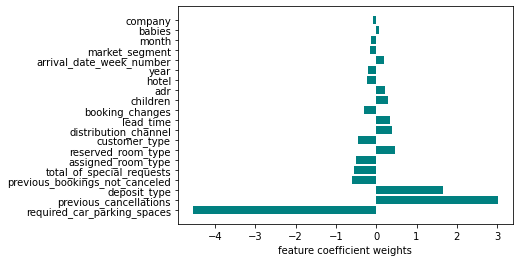

In [ ]:
from pandas import Series,DataFrame
print("The intercept is",lr.intercept_)

weights_f = Series(lr.coef_[0],
                 index=X_train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2 = weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2 = weights_f2.reset_index().rename(columns={'index': 'Features'})

# plot the feature weights
fig = plt.figure()
ax = plt.subplot(111)
ax.barh(weights_f2['Features'][:20], weights_f2['weights'][:20], color='teal')
ax.set_xlabel('feature coefficient weights')

### Decision Tree

DecisionTreeClassifier(max_depth=10)


 Confusion Matrix: Train: 
 


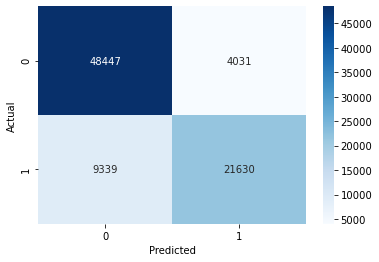



 Confusion Matrix: Test: 
 


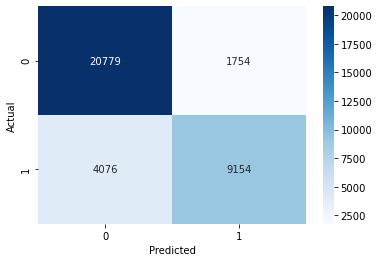



 AUC_ROC: Train: 
  0.9010453682119474
 AUC_ROC: Test: 
  0.8945789779592266


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     52478
           1       0.84      0.70      0.76     30969

    accuracy                           0.84     83447
   macro avg       0.84      0.81      0.82     83447
weighted avg       0.84      0.84      0.84     83447

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     22533
           1       0.84      0.69      0.76     13230

    accuracy                           0.84     35763
   macro avg       0.84      0.81      0.82     35763
weighted avg       0.84      0.84      0.83     35763

Accuracy Score of Decision Tree Model is : 0.8413164443698795


In [ ]:
dtc=DecisionTreeClassifier(max_depth=10)
modelEvaluation(dtc,X_train,y_train,X_test,y_test,threshold=0.4)

y_pred_dtc = dtc.predict(X_test)
acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree Model is : {acc_dtc}")

<AxesSubplot:>

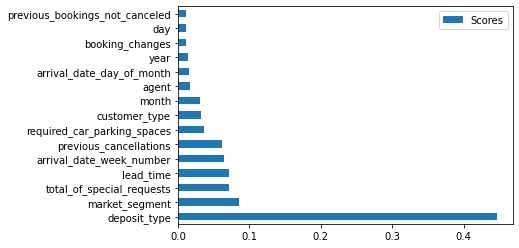

In [ ]:
#Feature Importance
pd.DataFrame(index=X_train.columns,data=dtc.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

### Random Forest

RandomForestClassifier(random_state=20)


 Confusion Matrix: Train: 
 


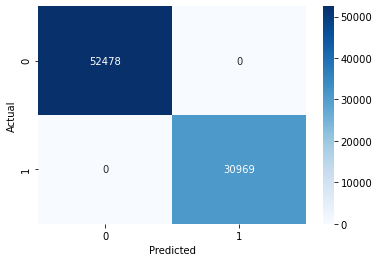



 Confusion Matrix: Test: 
 


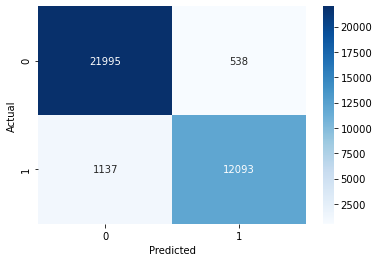



 AUC_ROC: Train: 
  1.0
 AUC_ROC: Test: 
  0.9857613872040334


Classification Report: Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     52478
           1       1.00      1.00      1.00     30969

    accuracy                           1.00     83447
   macro avg       1.00      1.00      1.00     83447
weighted avg       1.00      1.00      1.00     83447

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     22533
           1       0.96      0.91      0.94     13230

    accuracy                           0.95     35763
   macro avg       0.95      0.95      0.95     35763
weighted avg       0.95      0.95      0.95     35763

Accuracy Score of Random Forest Model is : 0.9492212621983614


In [ ]:
# print('Model: Random Forest\n')
rf = RandomForestClassifier(random_state=20)
modelEvaluation(rf,X_train,y_train,X_test,y_test,threshold=0.4)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score of Random Forest Model is : {acc_rf}")

### Gradient Boosting

GradientBoostingClassifier(random_state=20)


 Confusion Matrix: Train: 
 


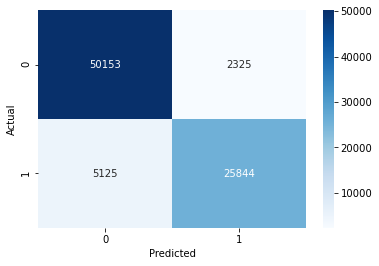



 Confusion Matrix: Test: 
 


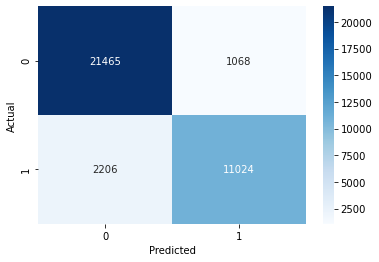



 AUC_ROC: Train: 
  0.956793147306161
 AUC_ROC: Test: 
  0.9553956204788953


Classification Report: Train 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     52478
           1       0.92      0.83      0.87     30969

    accuracy                           0.91     83447
   macro avg       0.91      0.90      0.90     83447
weighted avg       0.91      0.91      0.91     83447

Classification Report: Test 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     22533
           1       0.91      0.83      0.87     13230

    accuracy                           0.91     35763
   macro avg       0.91      0.89      0.90     35763
weighted avg       0.91      0.91      0.91     35763

Accuracy Score of Gradient Boosting Model is : 0.9002880071582362


In [ ]:
gb =GradientBoostingClassifier(random_state=20)
result_gb=modelEvaluation(gb,X_train,y_train,X_test,y_test,threshold = 0.4)

y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy Score of Gradient Boosting Model is : {acc_gb}")

<AxesSubplot:>

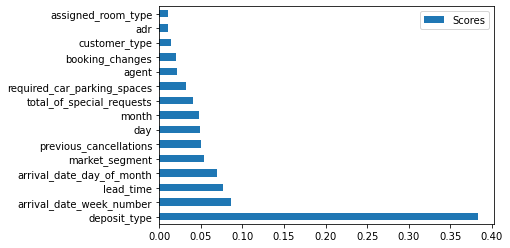

In [ ]:
#Feature importances
pd.DataFrame(index=X_train.columns,data=gb.feature_importances_,columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.barh()

In [ ]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression',  'Decision Tree Classifier', 'Random Forest Classifier',
             'Gradient Boosting Classifier'],
    'Score' : [acc_lr,  acc_dtc, acc_rf,acc_gb]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,Random Forest Classifier,0.949221
3,Gradient Boosting Classifier,0.900288
1,Decision Tree Classifier,0.841316
0,Logistic Regression,0.811146
